In [1]:
import pandas as pd
import random
import scipy as sp
import numpy as np
import cvxpy as cvx
import mosek
import matplotlib.pyplot as plt
import math
import warnings
import parameters
import simulations

#### Load Data

In [2]:
dfTripData = pd.read_csv("Data/location_data.csv")
dfLoadData = pd.read_csv("Data/use_data_2wk.csv") #365 days, 1 min increment, 142 houses 
dfGenData = pd.read_csv("Data/annual_capfac_15MinInterpolation.csv") #representative solar day, 15 min interval
#DAM
dfAsRDdamPrices=pd.read_csv("Data/AS_Prices/DAM/20190701_20190801_PRC_AS_DAM_REGDOWN.csv")
dfAsRUdamPrices=pd.read_csv("Data/AS_Prices/DAM/20190701_20190801_PRC_AS_DAM_REGUP.csv")

#RDU/RU RTM
dfAsRDrtmPrices=pd.read_csv("Data/AS_Prices/RTM/20190701_20190731_PRC_INTVL_AS_RTM_REGDOWN.csv")
dfAsRUrtmPrices=pd.read_csv("Data/AS_Prices/RTM/20190701_20190731_PRC_INTVL_AS_RTM_REGUP.csv")  
dfCostElectric = pd.read_csv("Data/TOU_Rate.csv") #15 min interal 4-9 pm, I think this is tou B

#### Script Parameters

In [3]:
intNumHouseNodes = 5
intNumCommNodes = 2
intTotalNodes = intNumHouseNodes + intNumCommNodes
intAvgNumCarsNode = 5 # goal is to have about 5 * 5 total cars
intSdNumCarsNode = 1
intProfiles = dfTripData.shape[0]

# could make battery parameters a randomized instantiation
fltCarEff = 3.95 # mi/kWh
fltBatteryCap = 40. # kWh
fltChargeRate = 1.9 # kW
fltDt = 0.25 # delta T
fltHomeRate = 7 # kW
fltWorkRate = 7 # kW

# time and conversion intervals
int_minutes=int(15)
int_run_days=2 # day
int_run_hours=24 # hours
int_run_time_interval=60/int_minutes #
time_kwh=15/60  # convert kw data to kwh


# cost to charge
lsCostElectric = []
lsHolder = dfCostElectric.values.tolist()
for ind in range(int_run_days):
    for n in lsHolder:
        lsCostElectric.append(n[0])

In [4]:
# call functions to get Nodes Dataframe
dfNodesTrips, intVeHouses = parameters.createCarsNodes(intNumHouseNodes, intNumCommNodes, intAvgNumCarsNode, intSdNumCarsNode, \
                    intProfiles, dfTripData)

#create df of loads for commercial & residential nodes
arrHouseLoads,dfNodeLoads, PeakTimes,PeakLoads, \
lsNodes,dctHomeNode = parameters.convertLoadData(dfLoadData,dfNodesTrips, \
                                    int_run_days,int_run_hours,int_minutes, intVeHouses,intNumCommNodes,intNumHouseNodes)

#create generation for 15 min increments for each node
arrHouseGen,dfNodeGens,npGenData = parameters.SolarGenData(dfGenData,int_run_days,int_run_hours,int_minutes, \
                                              intVeHouses,intNumCommNodes,intNumHouseNodes, dctHomeNode)


# now call function to get the SOC constraints array
arrSOCconstraint = parameters.getSOCconstraints(dfNodesTrips,\
                dfTripData, fltCarEff, fltChargeRate, fltDt, int_run_days)

# # call function to get an array of maximum charging rates and map to location by node
arrChargeRate, arrCanCharge,\
arrChargeLoc, arrHomeStation = parameters.MapCarNodesTime(int_minutes,\
                               int_run_hours,int_run_days, intVeHouses,dfNodesTrips,\
                               dfTripData, fltHomeRate, fltWorkRate)


# # call function to get initial SOCs of vehicles
# # replaces first column of soc constraint array
arrSOCconstraint = parameters.getInitialSoc(arrSOCconstraint, fltBatteryCap)  #should this have a different name?

# # call function to get power consumption of the vehicle
arrConsumptionFinal = parameters.findVehicleConsumption(dfNodesTrips, dfTripData, fltCarEff, \
                fltDt, int_run_days)

# #Get Ancillarys service values, the dict has 31 days for dam ru/rd and rtm ru/rd! can do a full run if we want
dctASallprices,lsDAMrdMax,lsDAMruMax,lsNetru,lsNetrd = parameters.processAsValues(dfAsRDdamPrices,dfAsRUdamPrices,dfAsRDrtmPrices,dfAsRUrtmPrices,int_run_days)



dfNetNodeLoad,arrNetHomeLoad,\
dctNodeIdentity, dctResIdentity = parameters.netLoadChargeLoc(arrHouseGen,arrHouseLoads,\
                                arrChargeLoc,dfNodeLoads,dfNodeGens,intVeHouses,\
                                intTotalNodes,lsNodes,int_minutes,int_run_hours, \
                                int_run_days, arrHomeStation)

lsRuIdentity, lsRdIdentity = parameters.dispatches(int_run_days, int_run_hours, int_run_time_interval, 0.1)

#create loop to run increasing dispatch amounts and save outputs


#### Vehicle AS Dispatch

In [6]:
constraints, varRegDown,varRegUp,\
varCharge,varNumberOfCycles, varDegradationCost= simulations.make_dispatch_constraints(arrSOCconstraint, arrChargeRate, arrCanCharge,\
                        dctNodeIdentity,lsNodes, arrConsumptionFinal,PeakLoads,intTotalNodes,dfNetNodeLoad,\
                     fltBatteryCap,fltDt,lsCostElectric,lsDAMrdMax,lsDAMruMax,\
                     lsRuIdentity, lsRdIdentity)
obj_value, varRegUp, varRegDown, varCharge =  simulations.make_dispatch_objectives(constraints, varRegDown,varRegUp,varCharge,varDegradationCost,\
                    lsCostElectric,lsRdIdentity, lsRuIdentity,lsDAMrdMax,lsDAMruMax,lsNetru,lsNetrd, fltDt)
    
# convex usually needs to be minimized
dispatchObj = cvx.Maximize(obj_value)
dispatchProb = cvx.Problem(dispatchObj, constraints)

dispatchProb.solve(solver=cvx.MOSEK)

223.59382547405073

In [ ]:
#values to save

fltObjective = obj_value.value
arrRuDispatches = varRegUp.value*lsRuIdentity  
arrRdDispatches = varRegDown.value*lsRuIdentity
arrDegradation = varDegradationCost.value # this is for each vehicle. sum? 
arrNumberCycles = varNumberOfCycles.value
fltRegUpVal = np.sum(varRegUp.value*lsDAMruMax)
fltRegDownVal = np.sum(varRegDown.value*lsDAMrdMax)

In [ ]:
#loop for dispatch quantity

lsObj=[]
lsCycles=[]
lsRegUpVal=[]
lsRegDownVal=[]


dfRegUp=pd.DataFrame()
dfRegDown=pd.DataFrame()
dfRegUpDispatch=pd.DataFrame()
dfRegDownDispatch=pd.DataFrame()
    
for j in np.linspace(0,1,11):
    lsRuIdentity, lsRdIdentity = parameters.dispatches(int_run_days, int_run_hours, int_run_time_interval, j)
    constraints, varRegDown,varRegUp,\
    varCharge,varNumberOfCycles, varDegradationCost= simulations.make_dispatch_constraints(arrSOCconstraint, arrChargeRate, arrCanCharge,\
                        dctNodeIdentity,lsNodes, arrConsumptionFinal,PeakLoads,intTotalNodes,dfNetNodeLoad,\
                     fltBatteryCap,fltDt,lsCostElectric,lsDAMrdMax,lsDAMruMax,\
                     lsRuIdentity, lsRdIdentity)
    obj_value, varRegUp, varRegDown, varCharge =  simulations.make_dispatch_objectives(constraints, varRegDown,varRegUp,varCharge,varDegradationCost,\
                    lsCostElectric,lsRdIdentity, lsRuIdentity,lsDAMrdMax,lsDAMruMax,lsNetru,lsNetrd, fltDt)
    
    dispatchObj = cvx.Maximize(obj_value)
    dispatchProb = cvx.Problem(dispatchObj, constraints)
    dispatchProb.solve(solver=cvx.MOSEK)
    
    arrRegUp=np.array(varRegUp.value)
    arrRegDown=np.array(varRegDown.value)
    arrRegDownDispatch=arrRegDown*lsRdIdentity
    arrRegUpDispatch=arrRegUp*lsRuIdentity
    arrDegradation = varDegradationCost.value # this is for each vehicle. sum? 
    lsObj.append(obj_value.value)
    lsCycles.append(varNumberOfCycles.value)
    lsRegUpVal.append(np.sum(arrRegUp*lsDAMruMax)+np.sum(arrRegUpDispatch*cvx.pos(lsNetru))/15)
    lsRegDownVal.append(np.sum(arrRegDown*lsDAMrdMax)+np.sum(arrRegDownDispatch*cvx.pos(lsNetrd))/15)
    
    dfRegUpDispatch.insert(j*10,"Dispatch"+str(j),arrRegDownDispatch)
    dfRegDownDispatch.insert(j*10,"Dispatch"+str(j),arrRegUpDispatch)
    dfRegUp.insert(j*10,"Dispatch"+str(j),arrRegUp)
    dfRegDown.insert=DataFrame(j*10,"Dispatch"+str(j),arrRegDown)
    
dfRegUp=DataFrame(list(zip(lsObj,lsCycles,lsRegUpVal,lsRegDownVal)),columns=["Obj Value","Cycles","Regup Value","Regdown Value"])
    
    

Text(0.5, 1.0, 'Regulation Down Dispatch')

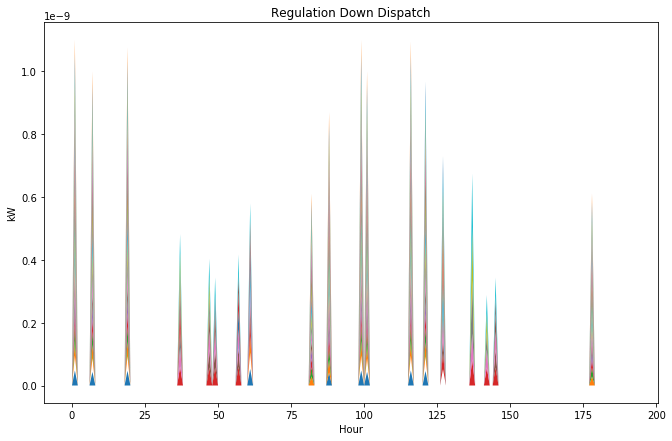

In [10]:
#graphs
arrRegDown = varRegDown.value*lsRdIdentity

fig, ax = plt.subplots(figsize=(11,7))
for ind in range(1,np.shape(arrRegDown)[1]):

    if ind == 1: 
        
        ax.fill_between(np.arange(96*2),np.zeros(96*2),np.array(arrRegDown[ind,:]).flatten())
    
    else: 
        
        lb = np.sum(arrRegDown[0:ind,:],axis=0)
        ub = np.sum(arrRegDown[0:ind+1,:],axis=0)
       
        ax.fill_between(np.arange(96*2),np.array(lb).flatten(),np.array(ub).flatten())


plt.ylabel('kW')
plt.xlabel("Hour")
plt.title("Regulation Down Dispatch")
# plt.savefig("regDown.png")

In [ ]:
arrRegUp = varRegUp.value*lsRuIdentity

fig, ax = plt.subplots(figsize=(11,7))
for ind in range(1,np.shape(arrRegUp)[1]):
    

    if ind == 1: 
        
        ax.fill_between(np.arange(96*2),np.zeros(96*2),np.array(arrRegUp[ind,:]).flatten())
    
    else: 
        
        lb = np.sum(arrRegUp[0:ind,:],axis=0)
        ub = np.sum(arrRegUp[0:ind+1,:],axis=0)
       
        ax.fill_between(np.arange(96*2),np.array(lb).flatten(),np.array(ub).flatten())

plt.ylabel('kW')
plt.xlabel("Hour of Day")
plt.title("Regulation Up Dispatch")
# plt.savefig("regUp.png")

#### Optimize for TOU only

In [ ]:
constraints, varCharge, varSOCs = simulations.make_tou_constraints(arrSOCconstraint, arrChargeRate, arrCanCharge,\
                                                fltDt, fltBatteryCap, arrConsumptionFinal,PeakLoads,intTotalNodes, dfNetNodeLoad)

tou_constraints, tou_obj_value = simulations.make_tou_objectives(constraints, varCharge,arrSOCconstraint,fltDt,lsCostElectric,arrConsumptionFinal)

touObj = cvx.Minimize(tou_obj_value)
touProb = cvx.Problem(touObj, tou_constraints)

touProb.solve(solver=cvx.MOSEK)

In [ ]:
#OUTPUTS
# THINGS TO SAVE !!
fltObjective = obj_value.value
arrRuDispatches = varRegUp.value*lsRuIdentity  
arrRdDispatches = varRegDown.value*lsRuIdentity
arrDegradation = varDegradationCost.value # this is for each vehicle. sum? 
arrNumberCycles = varNumberOfCycles.value
fltRegUpVal = np.sum(varRegUp.value*lsDAMruMax)
fltRegDownVal = np.sum(varRegDown.value*lsDAMrdMax)

In [ ]:
#graphs

#### Optimize a Stationary Battery

In [ ]:
lsResNodes = [strNode for strNode in lsNodes if "Res" in strNode]
constraints, varRegDown,varRegUp,varCharge,varDegradationCost = make_battery_constraints(arrSOCconstraint, arrChargeRate, dctResIdentity,lsResNodes, \
                     PeakLoads,intTotalNodes,dfNetNodeLoad,\
                     fltBatteryCap,fltDt,lsCostElectric,lsRdValueMax,lsRuValueMax,\
                     lsRuIdentity, lsRdIdentity, fltWorkRate)

bat_obj_value, varRegUp, varRegDown,varCharge = make_battery_objectives(constraints, varRegDown,varRegUp,varCharge,\
                                            varDegradationCost,lsCostElectric,lsRdValueMax,lsRuValueMax)


batObj = cvx.Maximize(bat_obj_value)
batProb = cvx.Problem(batObj, constraints)

batProb.solve(solver=cvx.MOSEK)

In [ ]:
#Calculate flex values

lsResNodes = [strNode for strNode in lsNodes if "Res" in strNode]
constraints, varRegDown,varRegUp,varCharge,varDegradationCost = make_battery_constraints(arrSOCconstraint, arrChargeRate, dctResIdentity,lsResNodes, \
                     PeakLoads,intTotalNodes,dfNetNodeLoad,\
                     fltBatteryCap,fltDt,lsCostElectric,lsRdValueMax,lsRuValueMax,\
                     lsRuIdentity, lsRdIdentity, fltWorkRate)

obj_value, varRegUp, varRegDown,varCharge = make_battery_objectives(constraints, varRegDown,varRegUp,varCharge,\
                                            varDegradationCost,lsCostElectric,lsRdValueMax,lsRuValueMax)


obj = cvx.Maximize(obj_value)
prob = cvx.Problem(obj, constraints)

prob.solve(solver=cvx.MOSEK)